In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from learnMSA.msa_hmm import (Align, Clustering, Configuration, Initializers,
                              Visualize)
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2025-05-09 11:26:16.610542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 11:26:16.626752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 11:26:16.631715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746782777.777196  779842 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746782777.819654  779842 cuda_executor.cc:1015] succ

### Ungapped alignment

In [2]:
name = "3_200"
suffix = "_no_gap"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"

# number of distinct pHMMs
num_models = 1

In [3]:
out_filename = "test/data/ungapped_default.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["max_surgery_runs"] = 1
    config["len_mul"] = 1.0
    initial_model_length_callback = partial(
        Align.get_initial_model_lengths, random=False
    )
    seq_weights = Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"])
    alignment_model = Align.run_learnMSA(
        data,
        out_filename,
        config, 
        sequence_weights=seq_weights,
        verbose=True,
        align_insertions=True,
        initial_model_length_callback=initial_model_length_callback,
        A2M_output=False #requires to run FastSP
    )

Training of 1 models on file 3_200_no_gap.fa
Configuration: 
{
num_models : 1
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single

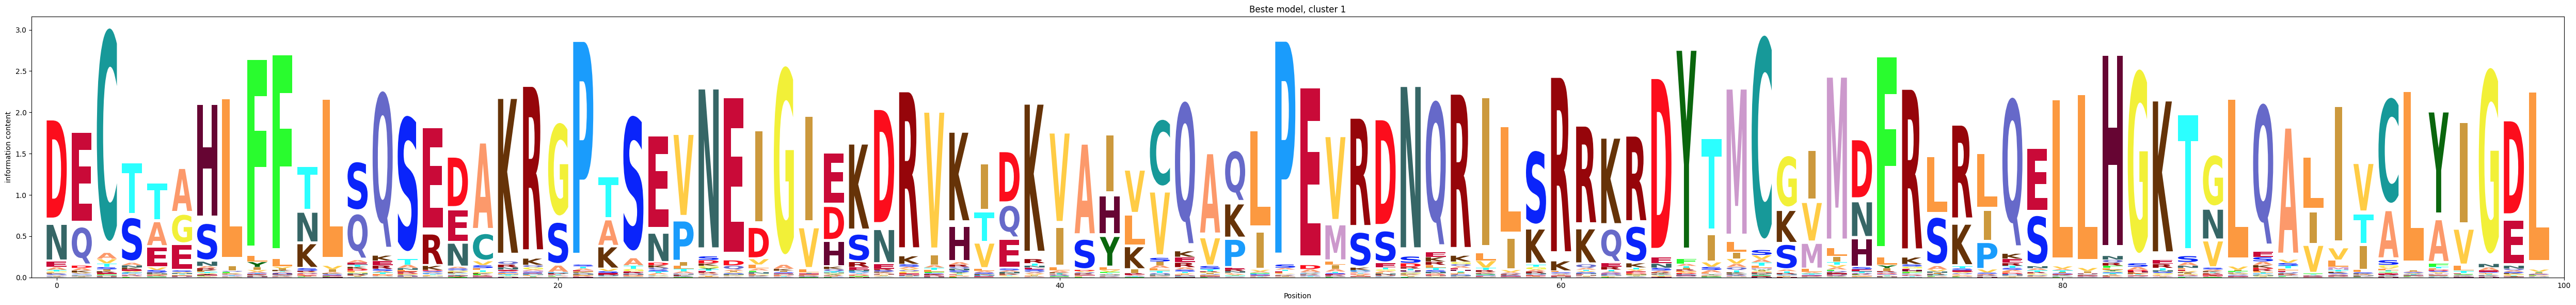

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(f"Beste model, cluster 1")
ax.set_xlabel("Position")
ax.set_ylabel("Information content")
Visualize.plot_logo(alignment_model, alignment_model.best_model, ax, cluster_index=0)
plt.tight_layout()